# Binary Relevance with KNN (implementation)

In this notebook, I will manually build separate models for each binary label. This is a common and valid technique in multilabel classification. This method is called the binary relevance method.

The idea behind binary relevance is to treat the multilabel classification problem as multiple independent binary classification problems, where for each label, you build a separate binary classifier that predicts whether that label is present (1) or not (0). Each classifier is trained using the same features, but only the target label for that particular classifier is used during training. The other labels are ignored during this process.

Binary relevance assumes no correlations or dependencies between the labels.

In [2]:
# Import important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## Loading the data

In [3]:
import os
# Set the working directory
os.chdir(r'/Users/saram/Desktop/Erdos_Institute/project/Data')

In [4]:
# Read train features
mars_data = pd.read_csv("../Data/train_features_new_with_PCA.csv")
mars_data.set_index(mars_data.sample_id, inplace=True)
mars_data

,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,...,2.12,0.13,1.13,2.13,0.14,1.14,2.14,0.15,1.15,2.15
sample_id,,,,,,,,,,,,,,,,,,,,,
S0000,S0000,0,0,0,0,0,0,0,0,1,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.270000e-15,1.300000e-15
S0001,S0001,0,1,0,0,0,0,0,0,0,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.270000e-15,1.300000e-15
S0002,S0002,0,0,0,0,0,1,0,0,0,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.270000e-15,1.300000e-15
S0003,S0003,0,1,0,1,0,0,0,0,1,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.270000e-15,1.300000e-15
S0004,S0004,0,0,0,1,0,1,1,0,0,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.270000e-15,1.300000e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0749,S0749,0,0,0,0,0,0,0,0,0,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.270000e-15,1.300000e-15
S0750,S0750,0,0,0,0,0,0,1,0,0,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.270000e-15,1.300000e-15
S0751,S0751,0,0,0,0,0,0,0,1,0,...,-0.09684,-0.983755,-0.177357,-0.178857,-0.559546,-0.15498,-0.039571,-0.362594,2.270000e-15,1.300000e-15


In [5]:
print(mars_data.columns)

Index(['sample_id', 'basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate',
       'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide', '0',
       '1', '2', '0.1', '1.1', '2.1', '0.2', '1.2', '2.2', '0.3', '1.3', '2.3',
       '0.4', '1.4', '2.4', '0.5', '1.5', '2.5', '0.6', '1.6', '2.6', '0.7',
       '1.7', '2.7', '0.8', '1.8', '2.8', '0.9', '1.9', '2.9', '0.10', '1.10',
       '2.10', '0.11', '1.11', '2.11', '0.12', '1.12', '2.12', '0.13', '1.13',
       '2.13', '0.14', '1.14', '2.14', '0.15', '1.15', '2.15'],
      dtype='object')


In [6]:
# Data preprocessing 
# Drop 'sample_id' and separate features and target labels
X = mars_data.drop(columns=['sample_id', 'basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine',
                       'phyllosilicate', 'silicate', 'sulfate', 'sulfide'])
y = mars_data[['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine',
          'phyllosilicate', 'silicate', 'sulfate', 'sulfide']]

In [7]:
# Ensure we have correct dimensions
print(X.shape)
print(y.shape)

(754, 48)
(754, 10)


In [8]:
print(y.columns)

Index(['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate',
       'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide'],
      dtype='object')


In [9]:
# Standardize the data
scalar = StandardScaler()
X = scalar.fit_transform(X)

## KNN Classification

In [10]:
labels = ['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine',
          'phyllosilicate', 'silicate', 'sulfate', 'sulfide']  # Label columns

# Hyperparameter grid for tuning KNN
param_grid = {
    'n_neighbors': range(1,11),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (p=1) or Euclidean (p=2)
}

# Store results for comparison
results = {}

# Loop through each label
for label in labels:
    y = mars_data[label]  # Binary target for the current label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize KNN classifier and GridSearchCV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid,
                                cv=5, # Specify cross-validation folds (5-fold cross-validation)
                                scoring='accuracy', n_jobs=-1)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model and make predictions
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Store results
    results[label] = {
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'classification_report': report
    }

    print(f"Label: {label}")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(report)

Label: basalt
Best Params: {'n_neighbors': 8, 'p': 1, 'weights': 'distance'}
Accuracy: 0.9007
Precision: 0.7000
Recall: 0.3684
F1 Score: 0.4828
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       132
           1       0.70      0.37      0.48        19

    accuracy                           0.90       151
   macro avg       0.81      0.67      0.71       151
weighted avg       0.89      0.90      0.89       151

Label: carbonate
Best Params: {'n_neighbors': 8, 'p': 2, 'weights': 'distance'}
Accuracy: 0.9536
Precision: 0.7692
Recall: 0.7143
F1 Score: 0.7407
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       137
           1       0.77      0.71      0.74        14

    accuracy                           0.95       151
   macro avg       0.87      0.85      0.86       151
weighted avg       0.95      0.95      0.95       151

Label: chloride
Best Params: {'n_neighbors': 6, 'p': 1,

In [11]:
labels = ['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine',
          'phyllosilicate', 'silicate', 'sulfate', 'sulfide']  # Label columns

# Placeholder for storing the results in a dictionary
report_data = {
    'Label': [],
    'Best Params': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Hyperparameter grid for tuning KNN
param_grid = {
    'n_neighbors': range(1,11),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (p=1) or Euclidean (p=2)
}

# Loop through each label
for label in labels:
    y = mars_data[label]  # Binary target for the current label
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize KNN classifier and GridSearchCV
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid,
                                cv=5, # Specify cross-validation folds (5-fold cross-validation)
                                scoring='accuracy', n_jobs=-1)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best model and make predictions
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results in the dictionary
    report_data['Label'].append(label)
    report_data['Best Params'].append(str(grid_search.best_params_))
    report_data['Accuracy'].append(accuracy)
    report_data['Precision'].append(precision)
    report_data['Recall'].append(recall)
    report_data['F1 Score'].append(f1)

# Create the DataFrame from the dictionary
report_df = pd.DataFrame(report_data)

# Display the DataFrame
report_df

,Label,Best Params,Accuracy,Precision,Recall,F1 Score
0,basalt,"{'n_neighbors': 8, 'p': 1, 'weights': 'distance'}",0.900662,0.700000,0.368421,0.482759
1,carbonate,"{'n_neighbors': 8, 'p': 2, 'weights': 'distance'}",0.953642,0.769231,0.714286,0.740741
2,chloride,"{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}",0.913907,1.000000,0.350000,0.518519
3,iron_oxide,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.894040,0.904762,0.575758,0.703704
4,oxalate,"{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}",0.993377,1.000000,0.888889,0.941176
5,oxychlorine,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.913907,0.800000,0.823529,0.811594
6,phyllosilicate,"{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}",0.860927,0.800000,0.750000,0.774194
7,silicate,"{'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}",0.900662,0.666667,0.421053,0.516129
8,sulfate,"{'n_neighbors': 6, 'p': 1, 'weights': 'distance'}",0.907285,0.800000,0.750000,0.774194
9,sulfide,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.986755,1.000000,0.500000,0.666667


## Taking the averages

In [12]:
# Take the average of each metric
average_accuracy = report_df['Accuracy'].mean()
average_precision = report_df['Precision'].mean()
average_recall = report_df['Recall'].mean()
average_f1 = report_df['F1 Score'].mean()

print(f"Average Accuracy: {average_accuracy:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1 Score: {average_f1:.4f}")

Average Accuracy: 0.9225
Average Precision: 0.8441
Average Recall: 0.6142
Average F1 Score: 0.6930


## Visualize the metrics for each class

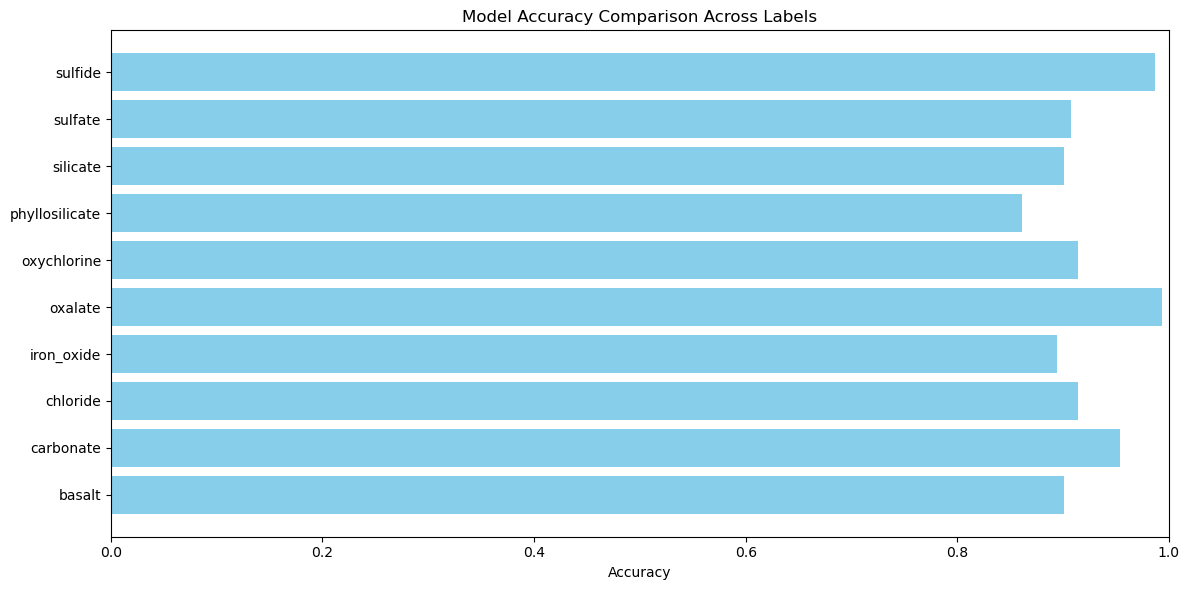

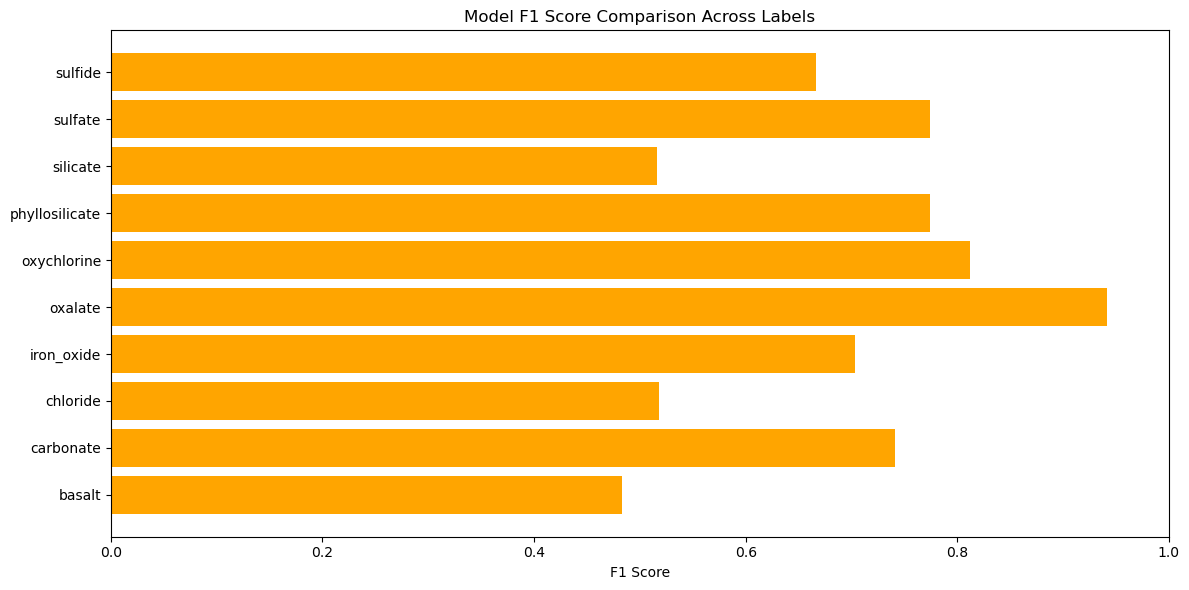

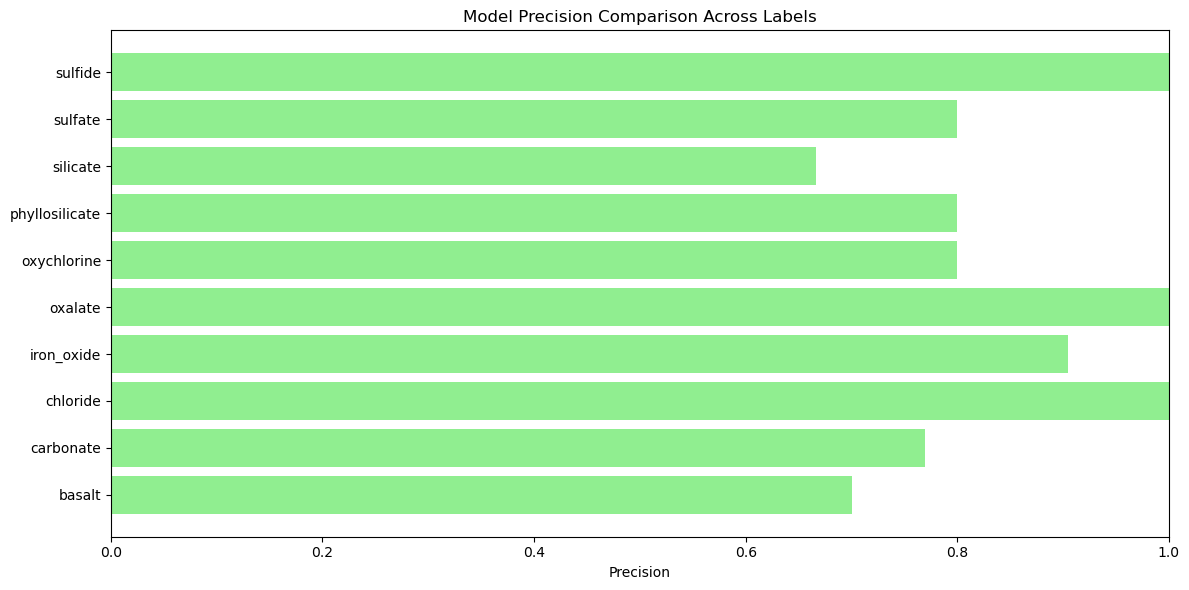

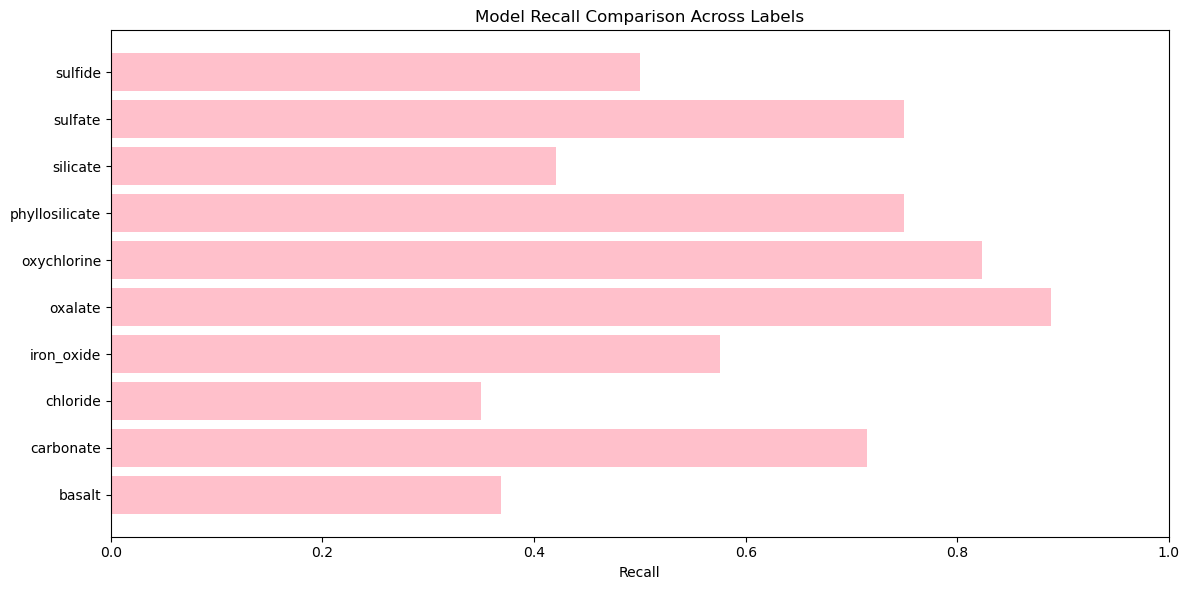

In [13]:
# Store the performance metrics for visualization
labels_list = list(results.keys())
accuracy_scores = [results[label]['accuracy'] for label in labels_list]
f1_scores = [results[label]['f1'] for label in labels_list]
precision_scores = [results[label]['precision'] for label in labels_list]
recall_scores = [results[label]['recall'] for label in labels_list]

# Plot Accuracy Scores
plt.figure(figsize=(12, 6))
plt.barh(labels_list, accuracy_scores, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison Across Labels')
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1
plt.tight_layout()
plt.show()

# Plot F1 Scores
plt.figure(figsize=(12, 6))
plt.barh(labels_list, f1_scores, color='orange')
plt.xlabel('F1 Score')
plt.title('Model F1 Score Comparison Across Labels')
plt.xlim(0, 1)  # F1 Score ranges from 0 to 1
plt.tight_layout()
plt.show()

# Plot Precision Scores
plt.figure(figsize=(12, 6))
plt.barh(labels_list, precision_scores, color='lightgreen')
plt.xlabel('Precision')
plt.title('Model Precision Comparison Across Labels')
plt.xlim(0, 1)  # Precision ranges from 0 to 1
plt.tight_layout()
plt.show()

# Plot Recall Scores
plt.figure(figsize=(12, 6))
plt.barh(labels_list, recall_scores, color='pink')
plt.xlabel('Recall')
plt.title('Model Recall Comparison Across Labels')
plt.xlim(0, 1)  # Recall ranges from 0 to 1
plt.tight_layout()
plt.show()


The **accuracy plot** appears uniform, which may indicate that the models are correctly predicting the majority class but could be less sensitive to minority class predictions. 

The **F1-score plot** shows variations in performance across labels, which is expected due to differences in data distributions or class imbalances for each label.

Some labels (*e.g., `oxalate` or `carbonate`*) have relatively high F1-scores, suggesting a good balance between precision and recall.
Others (*e.g., `silicate`*) may have lower F1-scores, indicating the need to examine issues like class imbalance, feature quality, or hyperparameter tuning.

This highlights why the F1-score (a balance of precision and recall) is often more informative for evaluating multi-label classification.

Thus, we need to rethink if we actually want to take the macro average for our model. If we directly average metrics calculated per label, then we are treating each label equally. 

However, we might consider micro average. This approach is especially useful when labels are imbalanced because it weights each prediction equally.

Check this further!